In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("APP_1").getOrCreate()

# Read ratings.csv
df = spark.read.csv("ratings.csv", header=True, inferSchema=True)

# Select first 100 unique users
unique_users = df.select("userId").distinct().limit(100)

# Keep only rows from these users
df_limited = df.join(unique_users, on="userId", how="inner")

df_limited.show(5)
print("Rows after limiting:", df_limited.count())
print("Unique users:", df_limited.select("userId").distinct().count())
print("Unique Movies:", df_limited.select("movieId").distinct().count())

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|    31|     47|   5.0|
|    31|     50|   4.0|
|    31|    296|   4.5|
|    31|    318|   5.0|
|    31|    608|   4.5|
+------+-------+------+
only showing top 5 rows
Rows after limiting: 17518
Unique users: 100
Unique Movies: 4943


In [2]:
from pyspark.ml.feature import StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.sql.functions import col, round as spark_round
from pyspark.ml.functions import vector_to_array

# Encode users
user_indexer = StringIndexer(inputCol="userId", outputCol="user")
df_small = user_indexer.fit(df_limited).transform(df_limited)

# Encode movies
movie_indexer = StringIndexer(inputCol="movieId", outputCol="movie")
df_small = movie_indexer.fit(df_small).transform(df_small)

# Min-Max on Ratings
assembler = VectorAssembler(inputCols=["rating"], outputCol="rating_vec")
df_vec = assembler.transform(df_small)

scaler = MinMaxScaler(inputCol="rating_vec", outputCol="rating_scaled")
scaler_model = scaler.fit(df_vec)
scaled_df = scaler_model.transform(df_vec)

# Flatten vector -> float, then round to 1 decimal
scaled_df = scaled_df.withColumn(
    "rating_scaled",
    spark_round(vector_to_array(col("rating_scaled"))[0], 1)
)

# Keep only necessary columns
df_final = scaled_df.select("user", "movie", "rating_scaled")
df_final.show(5)

+----+-----+-------------+
|user|movie|rating_scaled|
+----+-----+-------------+
|60.0| 24.0|          1.0|
|60.0|  9.0|          0.8|
|60.0|  4.0|          0.9|
|60.0|  0.0|          1.0|
|60.0| 25.0|          0.9|
+----+-----+-------------+
only showing top 5 rows


In [3]:
# Split df_final into 10 random parts (equal fractions)
fractions = [0.1] * 10   # 10 equal splits
splits = df_final.randomSplit(fractions, seed=42)

# Check the sizes
for i, part in enumerate(splits):
    n_users = part.select("user").distinct().count()
    n_movies = part.select("movie").distinct().count()
    print(f"Split {i+1}: {n_users} unique users, {n_movies} unique movies, {part.count()} rows")

Split 1: 97 unique users, 1268 unique movies, 1819 rows
Split 2: 98 unique users, 1245 unique movies, 1786 rows
Split 3: 99 unique users, 1298 unique movies, 1793 rows
Split 4: 98 unique users, 1217 unique movies, 1685 rows
Split 5: 94 unique users, 1218 unique movies, 1745 rows
Split 6: 97 unique users, 1207 unique movies, 1775 rows
Split 7: 99 unique users, 1213 unique movies, 1722 rows
Split 8: 100 unique users, 1202 unique movies, 1742 rows
Split 9: 98 unique users, 1174 unique movies, 1687 rows
Split 10: 98 unique users, 1252 unique movies, 1764 rows


In [4]:
for i, part in enumerate(splits):
    row = part.limit(1).collect() # Limit to one row and collect brings row from spark to python
    print(f"Model {i+1} sample row: {row}")

Model 1 sample row: [Row(user=0.0, movie=7.0, rating_scaled=0.8)]
Model 2 sample row: [Row(user=0.0, movie=27.0, rating_scaled=0.8)]
Model 3 sample row: [Row(user=0.0, movie=3.0, rating_scaled=0.6)]
Model 4 sample row: [Row(user=0.0, movie=12.0, rating_scaled=1.0)]
Model 5 sample row: [Row(user=0.0, movie=10.0, rating_scaled=0.8)]
Model 6 sample row: [Row(user=0.0, movie=1.0, rating_scaled=0.8)]
Model 7 sample row: [Row(user=0.0, movie=0.0, rating_scaled=0.8)]
Model 8 sample row: [Row(user=0.0, movie=9.0, rating_scaled=0.8)]
Model 9 sample row: [Row(user=0.0, movie=2.0, rating_scaled=0.8)]
Model 10 sample row: [Row(user=0.0, movie=6.0, rating_scaled=0.8)]


In [13]:
# import torch 

# all_data = []

# for i,part in enumerate(splits):
#     print(f"\n=== Processing Split {i+1} ===")

#     train_df,test_df = part.randomSplit([0.8, 0.2], seed=42)

#     # Convert to Pandas
#     train_pd = train_df.toPandas()
#     test_pd = test_df.toPandas()

#     # Step 3: convert to torch tensors
#     X_train = torch.tensor(train_pd[["user", "movie"]].values)
#     y_train = torch.tensor(train_pd["rating_scaled"].values)
    
#     X_test = torch.tensor(test_pd[["user", "movie"]].values)
#     y_test = torch.tensor(test_pd["rating_scaled"].values)
    
#     # Print stats
#     print("Train count:", X_train.shape[0], "| Train labels:", y_train.shape[0])
#     print("Test count:", X_test.shape[0], "| Test labels:", y_test.shape[0])

#     all_data.append({
#         "X_train": X_train,
#         "y_train": y_train,
#         "X_test": X_test,
#         "y_test": y_test
#     })


=== Processing Split 1 ===
Train count: 1503 | Train labels: 1503
Test count: 316 | Test labels: 316

=== Processing Split 2 ===
Train count: 1479 | Train labels: 1479
Test count: 307 | Test labels: 307

=== Processing Split 3 ===
Train count: 1485 | Train labels: 1485
Test count: 308 | Test labels: 308

=== Processing Split 4 ===
Train count: 1393 | Train labels: 1393
Test count: 292 | Test labels: 292

=== Processing Split 5 ===
Train count: 1444 | Train labels: 1444
Test count: 301 | Test labels: 301

=== Processing Split 6 ===
Train count: 1470 | Train labels: 1470
Test count: 305 | Test labels: 305

=== Processing Split 7 ===
Train count: 1425 | Train labels: 1425
Test count: 297 | Test labels: 297

=== Processing Split 8 ===
Train count: 1441 | Train labels: 1441
Test count: 301 | Test labels: 301

=== Processing Split 9 ===
Train count: 1395 | Train labels: 1395
Test count: 292 | Test labels: 292

=== Processing Split 10 ===
Train count: 1460 | Train labels: 1460
Test count: 30

In [5]:
import torch 

all_data = []

for i, part in enumerate(splits):
    print(f"\n=== Processing Split {i+1} ===")
   
    train_df, test_df = part.randomSplit([0.8, 0.2], seed=42)

    # Convert to Pandas
    train_pd = train_df.toPandas()
    test_pd = test_df.toPandas()

    # Make sure indices are integers
    train_pd["user"] = train_pd["user"].astype(int)
    train_pd["movie"] = train_pd["movie"].astype(int)
    test_pd["user"] = test_pd["user"].astype(int)
    test_pd["movie"] = test_pd["movie"].astype(int)

    # Convert to torch tensors
    X_train = torch.tensor(train_pd[["user", "movie"]].values, dtype=torch.long)  # for embedding
    y_train = torch.tensor(train_pd["rating_scaled"].values, dtype=torch.float)  # for MSE loss
    
    X_test = torch.tensor(test_pd[["user", "movie"]].values, dtype=torch.long)
    y_test = torch.tensor(test_pd["rating_scaled"].values, dtype=torch.float)

    # Print stats
    print("Train count:", X_train.shape[0], "| Train labels:", y_train.shape[0])
    print("Test count:", X_test.shape[0], "| Test labels:", y_test.shape[0])

    all_data.append({
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test
    })



=== Processing Split 1 ===
Train count: 1503 | Train labels: 1503
Test count: 316 | Test labels: 316

=== Processing Split 2 ===
Train count: 1479 | Train labels: 1479
Test count: 307 | Test labels: 307

=== Processing Split 3 ===
Train count: 1485 | Train labels: 1485
Test count: 308 | Test labels: 308

=== Processing Split 4 ===
Train count: 1393 | Train labels: 1393
Test count: 292 | Test labels: 292

=== Processing Split 5 ===
Train count: 1444 | Train labels: 1444
Test count: 301 | Test labels: 301

=== Processing Split 6 ===
Train count: 1470 | Train labels: 1470
Test count: 305 | Test labels: 305

=== Processing Split 7 ===
Train count: 1425 | Train labels: 1425
Test count: 297 | Test labels: 297

=== Processing Split 8 ===
Train count: 1441 | Train labels: 1441
Test count: 301 | Test labels: 301

=== Processing Split 9 ===
Train count: 1395 | Train labels: 1395
Test count: 292 | Test labels: 292

=== Processing Split 10 ===
Train count: 1460 | Train labels: 1460
Test count: 30

In [8]:
from torch.utils.data import TensorDataset, DataLoader

all_loaders = []  

for i, d in enumerate(all_data):
    # Create TensorDataset
    train_dataset = TensorDataset(d["X_train"], d["y_train"])
    test_dataset = TensorDataset(d["X_test"], d["y_test"])

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Save loaders for later training
    all_loaders.append({
        "train_loader": train_loader,
        "test_loader": test_loader
    })

print(f"\nCreated DataLoaders for {len(all_loaders)} splits")


Created DataLoaders for 10 splits


In [9]:
import torch.nn as nn

class CollabFiltering(nn.Module):
    def __init__(self, n_users, n_movies, emb_dim, hidden, dropout_p):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, emb_dim)   #n_users * emb_dim = 50 * 16 = 800
        self.movie_emb = nn.Embedding(n_movies, emb_dim)  #n_movies * emb_dim = 3524 * 16 = 56,384

        self.mlp = nn.Sequential(
            nn.Linear(emb_dim * 2, hidden),  # user+movie embeddings concatenated 16*2*32 + 32 = 1056
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(hidden, 1),  #32*1 + 1 = 33
            nn.Sigmoid()  # predict rating
        )

    def forward(self,user,movie):
        u = self.user_emb(user)
        m = self.movie_emb(movie)
        
        # Concatenate embeddings (instead of dot product)
        x = torch.cat([u, m], dim=1)
        
        # Pass through MLP
        return self.mlp(x).squeeze()

# n_users and n_movies calculated earlier

In [10]:
loss_fn = nn.MSELoss() # regression on ratings

def adam(parameter, m_state, v_state, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    # Loop over Tensors in model.parameters()
    for p in parameter:
        if p.grad is None:
            continue

        # First Time seeing this parameter
        if p not in m_state:
            m_state[p] = torch.zeros_like(p)
            v_state[p] = torch.zeros_like(p)

        g = p.grad
        # First moment
        m_state[p] = beta1 * m_state[p] + (1 - beta1) * g
        # Second moment
        v_state[p] = beta2 * v_state[p] + (1 - beta2) * (g * g)

        # Bias correction
        m_corrected = m_state[p] / (1 - beta1 ** t)
        v_corrected = v_state[p] / (1 - beta2 ** t)

        # Parameter update (in-place)
        p.data -= lr * m_corrected / (torch.sqrt(v_corrected) + epsilon)

    return m_state, v_state


In [33]:
epochs = 100

# ---- Global counts (based on full df_final) ----
n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

# Loop over splits and loaders together
for i, loaders in enumerate(all_loaders, start=1):
    print(f"\n================ Training Model {i} on Split {i} ================")
    
    # Reset model, optimizer states and loss list
    model = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=32, dropout_p=0.3)

    m_state, v_state = {}, {}
    t = 0
    
    train_losses, test_losses = [], []
    train_rmses, test_rmses = [], []

    train_loader = loaders["train_loader"]
    test_loader = loaders["test_loader"]   # ✅ fixed

    for epoch in range(epochs):
        # ---------- Training ----------
        model.train()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        
        for X_batch, y_batch in train_loader:
            user_batch = X_batch[:, 0].long()
            movie_batch = X_batch[:, 1].long()
            
            preds = model(user_batch, movie_batch).squeeze()
            loss = loss_fn(preds, y_batch.float())
            
            model.zero_grad()
            loss.backward()
            
            # Custom Adam
            t += 1
            m_state, v_state = adam(model.parameters(), m_state, v_state, t)
            
            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)
        
        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5
        train_losses.append(train_loss)
        train_rmses.append(train_rmse)

        # ---------- Testing ----------
        model.eval()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                user_batch = X_batch[:, 0].long()
                movie_batch = X_batch[:, 1].long()
                
                preds = model(user_batch, movie_batch).squeeze()
                loss = loss_fn(preds, y_batch.float())
                
                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)
        
        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5
        test_losses.append(test_loss)
        test_rmses.append(test_rmse)
        
        # ---------- Summary ----------
        if (epoch + 1) % 10 == 0:
            print(f"\nEpoch {epoch+1}/{epochs}")  # ✅ fixed
            print(f"Train Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}")
            print(f"Test  Loss: {test_loss:.4f}, Test  RMSE: {test_rmse:.4f}")




================ Training Model 1 on Split 1 ================
<generator object Module.parameters at 0x000001821E661460>

Epoch 10/100
Train Loss: 0.0185, Train RMSE: 0.1355
Test  Loss: 0.0646, Test  RMSE: 0.2546

Epoch 20/100
Train Loss: 0.0094, Train RMSE: 0.0968
Test  Loss: 0.0721, Test  RMSE: 0.2690

Epoch 30/100
Train Loss: 0.0065, Train RMSE: 0.0805
Test  Loss: 0.0733, Test  RMSE: 0.2714

Epoch 40/100
Train Loss: 0.0047, Train RMSE: 0.0687
Test  Loss: 0.0776, Test  RMSE: 0.2793

Epoch 50/100
Train Loss: 0.0046, Train RMSE: 0.0678
Test  Loss: 0.0775, Test  RMSE: 0.2790

Epoch 60/100
Train Loss: 0.0038, Train RMSE: 0.0616
Test  Loss: 0.0761, Test  RMSE: 0.2766

Epoch 70/100
Train Loss: 0.0036, Train RMSE: 0.0602
Test  Loss: 0.0779, Test  RMSE: 0.2798

Epoch 80/100
Train Loss: 0.0032, Train RMSE: 0.0560
Test  Loss: 0.0779, Test  RMSE: 0.2799

Epoch 90/100
Train Loss: 0.0030, Train RMSE: 0.0553
Test  Loss: 0.0798, Test  RMSE: 0.2832

Epoch 100/100
Train Loss: 0.0034, Train RMSE: 0.0

In [11]:
epochs = 100
all_result = []

n_users_global = df_final.select("user").distinct().count()
n_movies_global = df_final.select("movie").distinct().count()

for i, (part, loaders) in enumerate(zip(splits, all_loaders), start=1):
    print(f"\n================ Training Model {i} on Split {i} ================")

    model = CollabFiltering(n_users_global, n_movies_global, emb_dim=16, hidden=32, dropout_p=0.3)
    m_state, v_state = {}, {}
    t = 0

    train_loader = loaders["train_loader"]
    test_loader = loaders["test_loader"]

    best_rmse = float("inf")
    best_state = None
    best_epoch = -1

    train_losses, test_losses = [], []
    train_rmses, test_rmses = [], []

    for epoch in range(epochs):
        # ---------- Training ----------
        model.train()
        total_loss, total_sq_error, total_samples = 0, 0, 0

        for X_batch, y_batch in train_loader:
            user_batch = X_batch[:, 0].long()
            movie_batch = X_batch[:, 1].long()

            preds = model(user_batch, movie_batch).squeeze()
            loss = loss_fn(preds, y_batch.float())

            model.zero_grad()
            loss.backward()

            # Custom Adam
            t += 1
            m_state, v_state = adam(model.parameters(), m_state, v_state, t)

            total_loss += loss.item()
            total_sq_error += torch.sum((preds - y_batch) ** 2).item()
            total_samples += len(y_batch)

        train_loss = total_loss / len(train_loader)
        train_rmse = (total_sq_error / total_samples) ** 0.5
        train_losses.append(train_loss)
        train_rmses.append(train_rmse)

        # ---------- Testing ----------
        model.eval()
        total_loss, total_sq_error, total_samples = 0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                user_batch = X_batch[:, 0].long()
                movie_batch = X_batch[:, 1].long()

                preds = model(user_batch, movie_batch).squeeze()
                loss = loss_fn(preds, y_batch.float())

                total_loss += loss.item()
                total_sq_error += torch.sum((preds - y_batch) ** 2).item()
                total_samples += len(y_batch)

        test_loss = total_loss / len(test_loader)
        test_rmse = (total_sq_error / total_samples) ** 0.5
        test_losses.append(test_loss)
        test_rmses.append(test_rmse)

        # ---------- Checkpoint ----------
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_epoch = epoch + 1
            best_state = model.state_dict()

    # ---------------- After Training: restore best checkpoint ----------------
    print(f"\nBest checkpoint for Split {i} was at Epoch {best_epoch} with Test RMSE = {best_rmse:.4f}")
    model.load_state_dict(best_state)

    # ---------- Capture gradients at best checkpoint ----------
    model.train()
    X_batch, y_batch = next(iter(train_loader))  # one batch is enough
    user_batch = X_batch[:, 0].long()
    movie_batch = X_batch[:, 1].long()

    preds = model(user_batch, movie_batch).squeeze()
    loss = loss_fn(preds, y_batch.float())

    model.zero_grad()
    loss.backward()

    # Print gradients
    print(f"\nGradients at best checkpoint (Split {i}):")
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name}: mean={param.grad.mean().item():.6f}, std={param.grad.std().item():.6f}")

    # Save results
    all_result.append({
        "split": i,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_rmses": train_rmses,
        "test_rmses": test_rmses,
        "best_epoch": best_epoch,
        "best_rmse": best_rmse
    })


================ Training Model 1 on Split 1 ================

Best checkpoint for Split 1 was at Epoch 4 with Test RMSE = 0.2265

Gradients at best checkpoint (Split 1):
user_emb.weight: mean=0.000001, std=0.000043
movie_emb.weight: mean=-0.000000, std=0.000007
mlp.0.weight: mean=0.000018, std=0.000182
mlp.0.bias: mean=0.000085, std=0.000161
mlp.3.weight: mean=0.000544, std=0.001483
mlp.3.bias: mean=0.000580, std=nan

================ Training Model 2 on Split 2 ================


C:\Users\GOUTHAM\AppData\Local\Temp\ipykernel_22000\2792601783.py:98: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\ReduceOps.cpp:1823.)
  print(f"{name}: mean={param.grad.mean().item():.6f}, std={param.grad.std().item():.6f}")



Best checkpoint for Split 2 was at Epoch 3 with Test RMSE = 0.2260

Gradients at best checkpoint (Split 2):
user_emb.weight: mean=0.000000, std=0.000044
movie_emb.weight: mean=-0.000000, std=0.000007
mlp.0.weight: mean=-0.000009, std=0.000206
mlp.0.bias: mean=-0.000074, std=0.000200
mlp.3.weight: mean=0.000342, std=0.001944
mlp.3.bias: mean=0.001788, std=nan

================ Training Model 3 on Split 3 ================

Best checkpoint for Split 3 was at Epoch 3 with Test RMSE = 0.2246

Gradients at best checkpoint (Split 3):
user_emb.weight: mean=0.000000, std=0.000036
movie_emb.weight: mean=-0.000000, std=0.000006
mlp.0.weight: mean=0.000010, std=0.000152
mlp.0.bias: mean=0.000028, std=0.000146
mlp.3.weight: mean=0.000075, std=0.001438
mlp.3.bias: mean=-0.000868, std=nan

================ Training Model 4 on Split 4 ================

Best checkpoint for Split 4 was at Epoch 3 with Test RMSE = 0.2429

Gradients at best checkpoint (Split 4):
user_emb.weight: mean=0.000001, std=0.0000

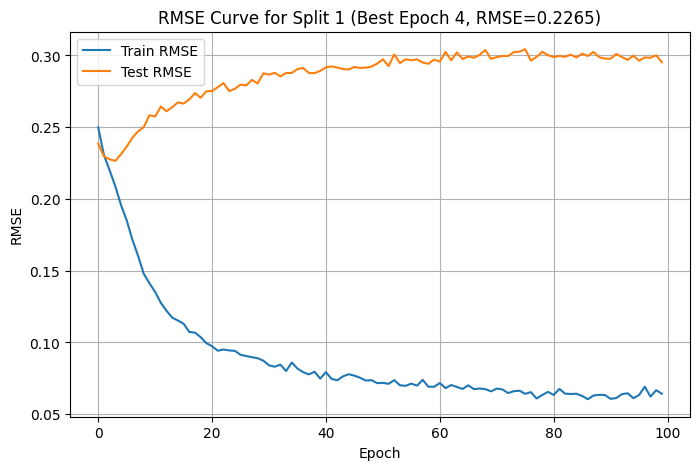

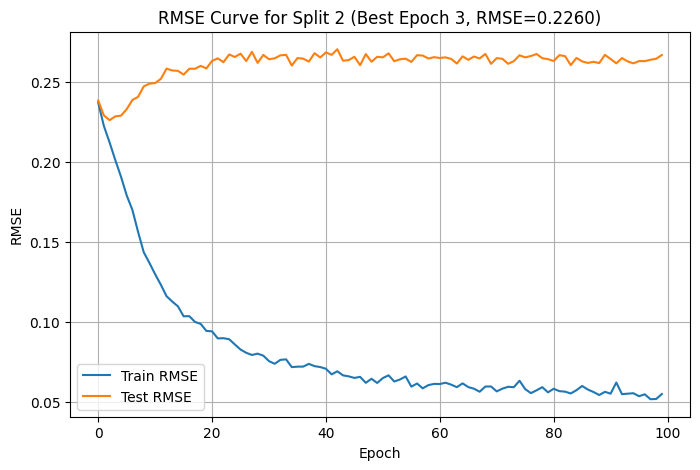

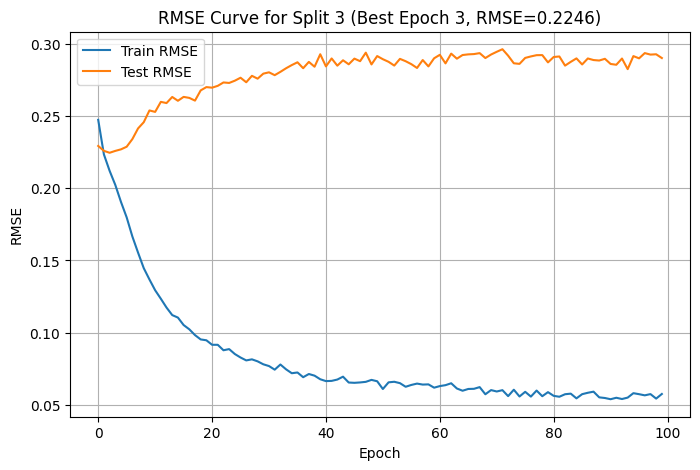

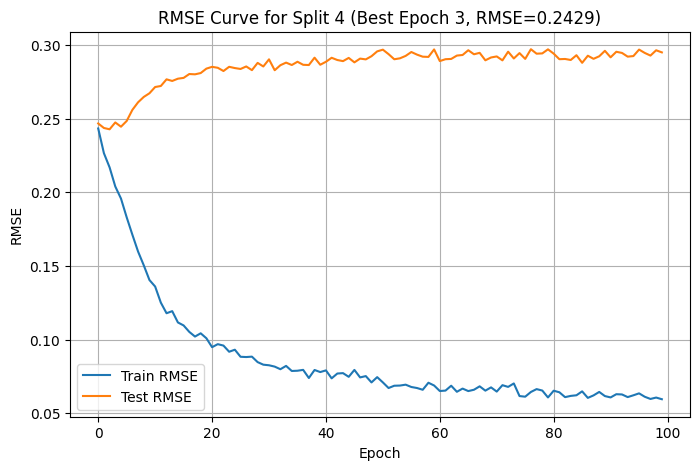

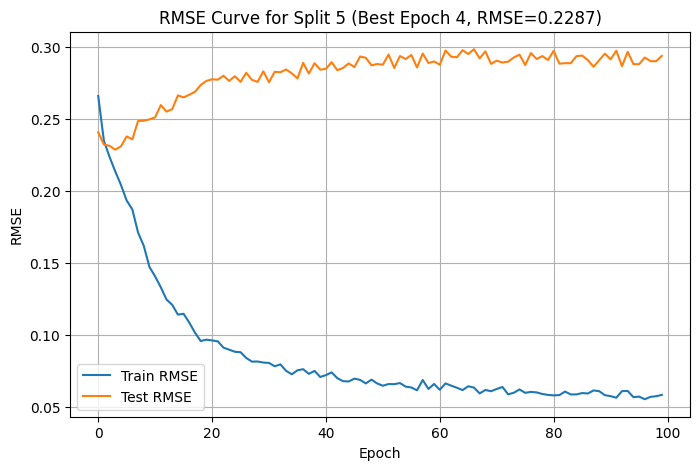

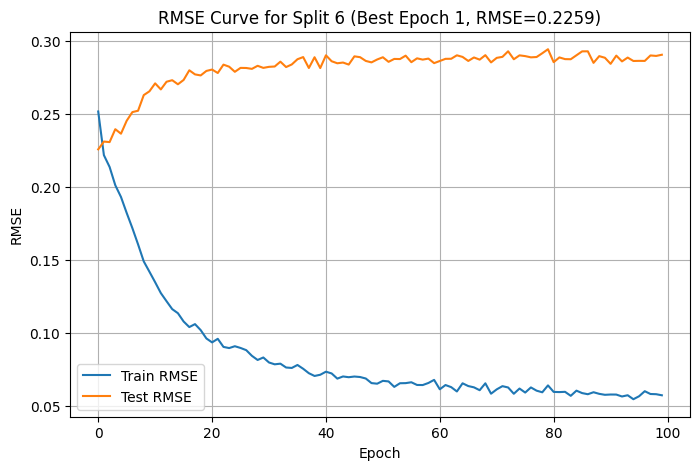

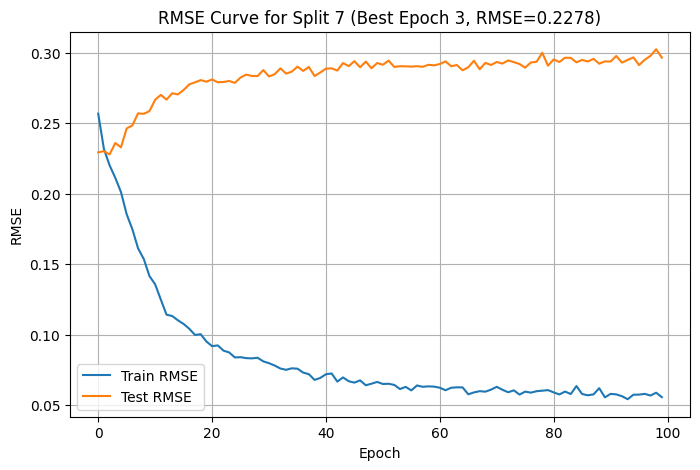

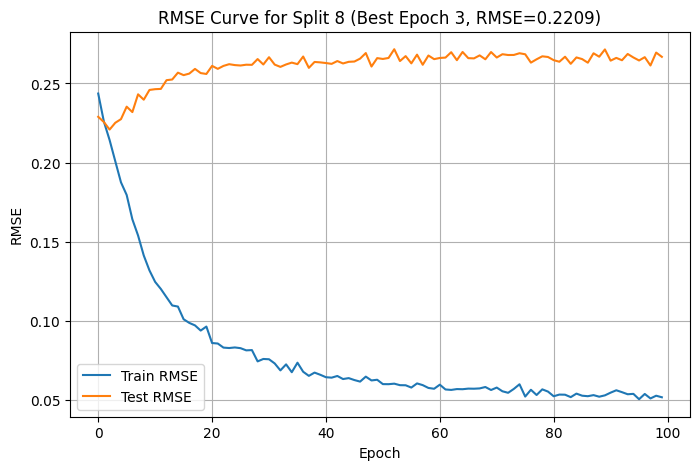

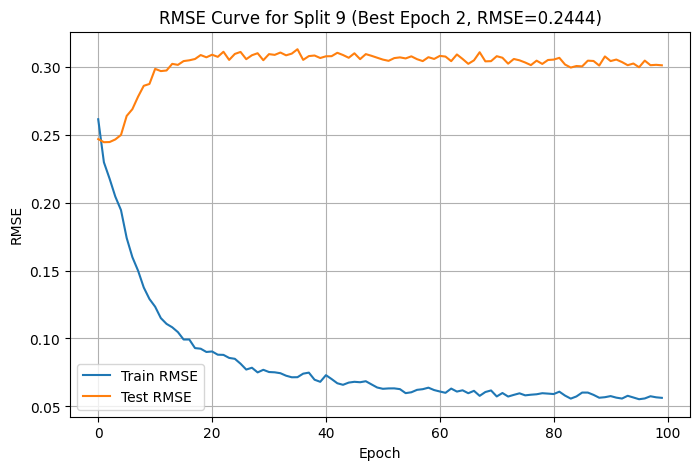

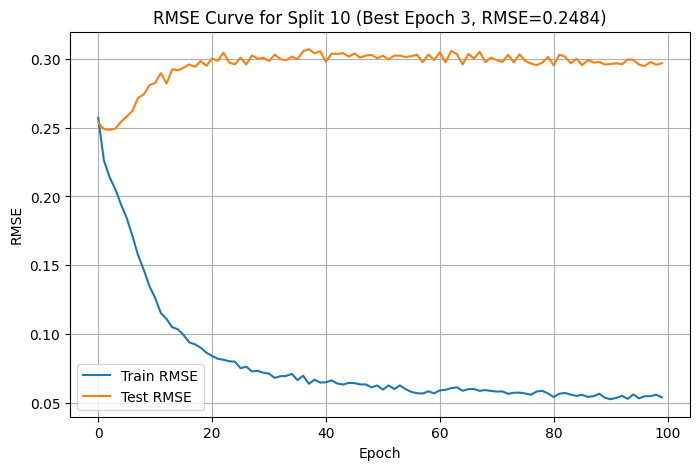

In [13]:
import matplotlib.pyplot as plt

# Plot losses for each split
for result in all_result:
    split = result["split"]
    train_rmses = result["train_rmses"]
    test_rmses = result["test_rmses"]

    plt.figure(figsize=(8,5))
    plt.plot(train_rmses, label="Train RMSE")
    plt.plot(test_rmses, label="Test RMSE")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title(f"RMSE Curve for Split {split} (Best Epoch {result['best_epoch']}, RMSE={result['best_rmse']:.4f})")
    plt.legend()
    plt.grid(True)
    plt.show()
